# **Analisis y clasificación del dataseet BCI competition IV 2b con el algoritmo FBCSP**

## **1. Comprensión del problema**

### **1.1. Dataseet Competition IV 2b**

Son señales EEG tomadas en 5 sesiones por cada sujeto para 9 sujetos donde en cada sesión se usaron 3 canales (C3, Cz y C4) muestreadas a 250 Hz y filtradas con un pasabandas entre 0.5 Hz y 100 Hz, con un filtro Notch a 50 Hz para eliminar ruido electrico. Tambien se usaron canales EOG en los 5 primeros minutos de duración.

## **2. Comprensión de los datos**

In [105]:
import os
import numpy as np
import mne # Libreria para análisis de EEG
import matplotlib.pyplot as plt
from mne.filter import filter_data
from mne.decoding import CSP
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Cargamos el archivo GDF del sujeto 1 de entrenamiento del dataseet 2a con mne
ruta = r'F:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Dataseets\BCICIV_2b_gdf\B0101T.gdf'
raw = mne.io.read_raw_gdf(ruta, preload = True) 
raw.drop_channels(['EOG:ch01', 'EOG:ch02', 'EOG:ch03']) # Eliminamos los canales de EOG, quedandonos con los 22 canales EEG

Extracting EDF parameters from F:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Dataseets\BCICIV_2b_gdf\B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\dell\AppData\Local\Temp\ipykernel_15096\1952897360.py:16: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(ruta, preload = True)


<RawGDF | B0101T.gdf, 3 x 604803 (2419.2 s), ~13.9 MiB, data loaded>

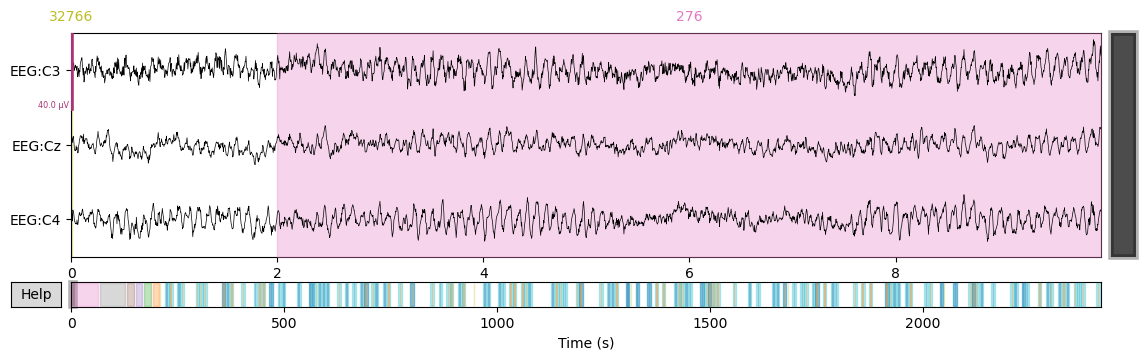

In [106]:
# Grafica de las señales EEG
fig = raw.plot(scalings={'eeg': 20e-6}, show=False)
fig.set_size_inches(12, 3) # Ajustamos el tamaño de la figura a 12(ancho)x3(altura) pulgadas
plt.show()

Descartando los canales pertenecientes a EOG tenemos 3 canales de EEG (C3, Cz y C4)

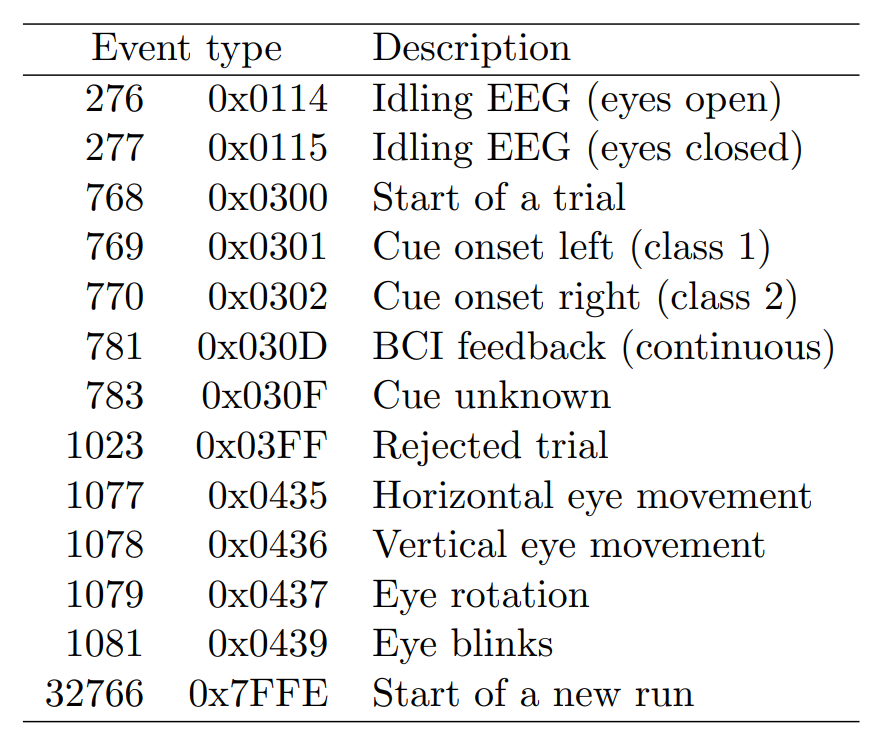

In [107]:
events = mne.events_from_annotations(raw) # Extraemos los eventos de las anotaciones del archivo GDF
events # Imprimimos los eventos

Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']


(array([[     0,      0,      8],
        [   499,      0,      6],
        [ 16749,      0,      7],
        [ 32999,      0,      5],
        [ 37999,      0,      4],
        [ 42999,      0,      3],
        [ 47999,      0,      2],
        [ 52251,      0,      8],
        [ 55139,      0,      9],
        [ 55889,      0,     10],
        [ 57499,      0,      9],
        [ 58249,      0,     11],
        [ 62067,      0,      9],
        [ 62817,      0,     10],
        [ 64104,      0,      9],
        [ 64854,      0,     11],
        [ 72981,      0,      9],
        [ 73731,      0,     11],
        [ 75188,      0,      9],
        [ 75938,      0,     11],
        [ 77589,      0,      9],
        [ 78339,      0,     11],
        [ 88500,      0,      9],
        [ 88500,      0,      1],
        [ 89250,      0,     11],
        [ 90934,      0,      9],
        [ 91684,      0,     10],
        [ 93193,      0,      9],
        [ 93943,      0,     11],
        [ 9995

Como nos indico el paper, extraemos los eventos enumerados del dataseet, dentro de los cuales los importantes son:
- 769 -> Imaginación motora de mano izquierda
- 770 -> Imaginación motora de mano derecha

C:\Users\dell\AppData\Local\Temp\ipykernel_15096\3790061626.py:15: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


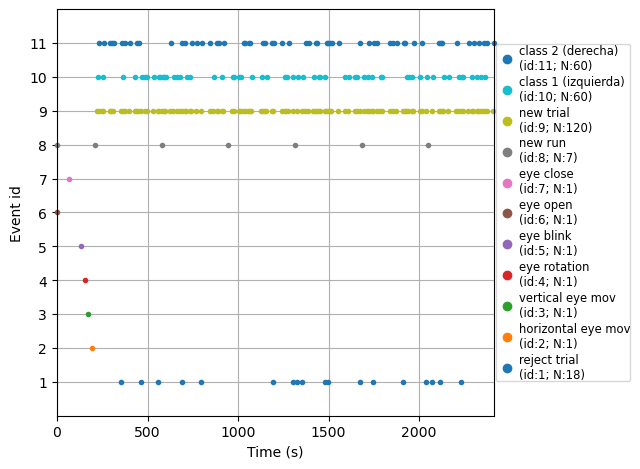

In [108]:
event_dict = {
    'reject trial': 1, # No lo necesitamos
    'horizontal eye mov': 2, # No lo necesitamos
    'vertical eye mov': 3, # No lo necesitamos
    'eye rotation': 4, # No lo necesitamos
    'eye blink': 5, # No lo necesitamos
    'eye open': 6, # No lo necesitamos
    'eye close': 7, # No lo necesitamos
    'new run': 8, # Inicio de una nuevo ensayo
    'new trial': 9, # Ensayos que debemos descartar debido a que contienen artefactos (Etiquetados por expertos)
    'class 1 (izquierda)': 10, # Imaginacion motora de mano izquierda
    'class 2 (derecha)': 11, # Imaginacion motora de mano derecha
}
# Visualizamos los eventos
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

Destacamos que contamos con 60 ensayos para imaginacion motora de mano derecha y 60 para imaginación motora de mano izquierda. Dando un total de 120 ensayos, de los cuales 18 deberian ser descartados por contener artefactos y no deberian ser usados para el entrenamiento. Por otra parte la duración entera de la sesión fue aproximadamente 2460 segundos (41 minutos).

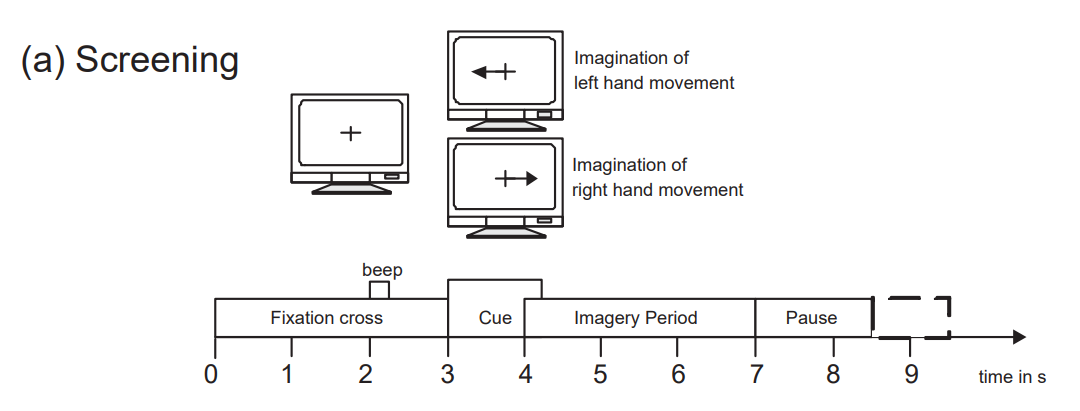

In [109]:
# Creamos los epochs de 3 segundos para Motor Imagery de mano izquierda y derecha (Imagery Period como indica el paper)
epoch = mne.Epochs(raw, events=events[0], event_id=[10,11], tmin = 1, tmax = 4, baseline=None) 
epoch.get_data().shape # (n_epochs, n_channels, n_times) = (120, 3, 751)
# NOTA: El paper nos indica que la etiqueta de 769 o 770 se coloca justamente cuando inicia a mostrarse el cue visual, 
# por lo que debemos cortar los epochs de 1 a 4 segundos para obtener la parte de Imagery Period

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 751 original time points ...
0 bad epochs dropped


(120, 3, 751)

Using data from preloaded Raw for 2 events and 751 original time points ...


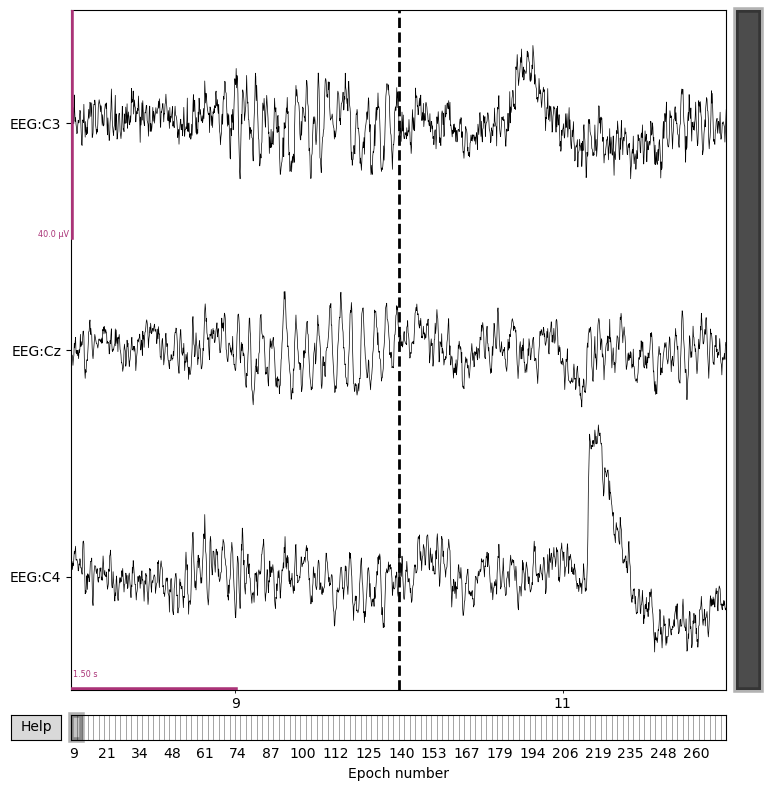

In [110]:
epoch.plot(scalings={'eeg': 20e-6}, n_epochs=2, title='Epoch 1')
fig.set_size_inches(12, 1)

Estamos mostrando 2 epochs por ejemplo, separados por una linea punteada. Con los valores no escalados para una mejor visualización.

In [111]:
labels = epoch.events[:, -1] # Seleccionamos la ultima columna de la matriz de eventos que tenia 3 columnas
labels # 10 = Movimiento de mano izquierda, 11 = Movimiento de mano derecha, deberia haber 60 de cada uno

array([10, 11, 10, 11, 11, 11, 11, 11, 10, 11, 11, 10, 11, 11, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 11, 11, 10, 10, 11, 11, 11,
       11, 10, 11, 11, 10, 11, 10, 10, 10, 10, 11, 11, 11, 11, 10, 10, 11,
       11, 10, 11, 11, 11, 10, 10, 11, 10, 10, 10, 11, 11, 10, 11, 11, 10,
       10, 10, 11, 11, 11, 11, 11, 10, 10, 10, 10, 11, 10, 10, 11, 10, 11,
       11, 10, 10, 11, 11, 11, 11, 11, 10, 10, 10, 11, 10, 11, 10, 10, 11,
       11, 11, 10, 10, 11, 10, 10, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11,
       11])

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


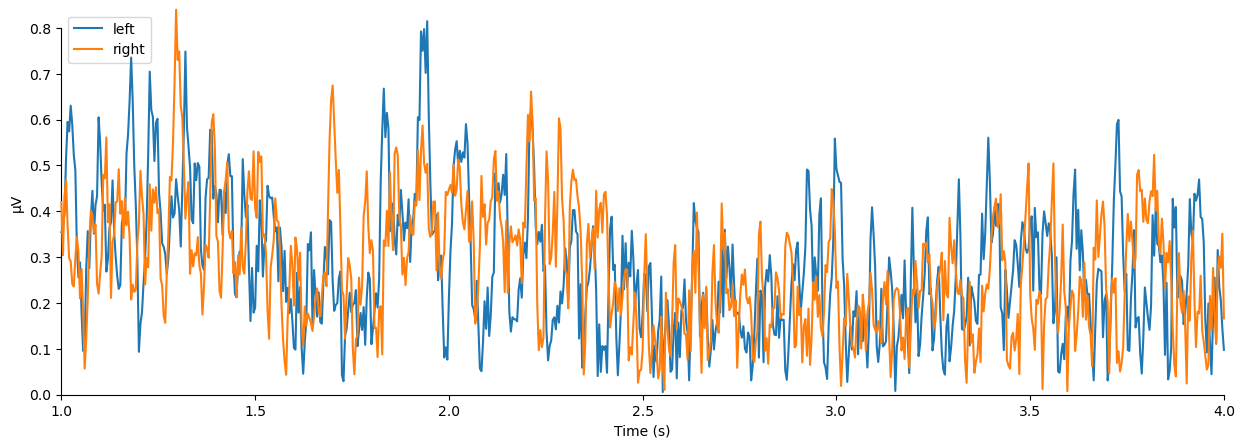

[<Figure size 1500x500 with 1 Axes>]

In [112]:
evoked_left = epoch['10'].average() # Promedio de todos los epochs de MI de mano izquierda
evoked_right = epoch['11'].average() # Promedio de todos los epochs de MI de mano derecha
dicts = {'left': evoked_left, 'right': evoked_right}
fig, ax = plt.subplots(figsize=(15, 5))  # ancho=10, alto=5
mne.viz.plot_compare_evokeds(dicts, axes=ax, show=True)

Notamos una visualización de lo que sería un evoked potential, el promedio de todos los epochs para todos los canales

In [113]:
features = epoch.get_data() # Extraemos los datos de los epochs en un array 3D (n_epochs, n_channels, n_times)
# Labels nos muestra el numero de trials y features nos muestra los datos de los epochs
labels.shape, features.shape 

Using data from preloaded Raw for 120 events and 751 original time points ...


((120,), (120, 3, 751))

In [114]:
def filter_band_features(features, fs, flow, fhigh):
    filtered_features = filter_data(features, fs, flow, fhigh)
    return filtered_features
filtered_mu = filter_band_features(features, fs=250, flow=8, fhigh=13)
filtered_beta = filter_band_features(features, fs=250, flow=13, fhigh=30)
print(filtered_mu.shape)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- F

Creating RawArray with float64 data, n_channels=3, n_times=751
    Range : 0 ... 750 =      0.000 ...     3.000 secs
Ready.


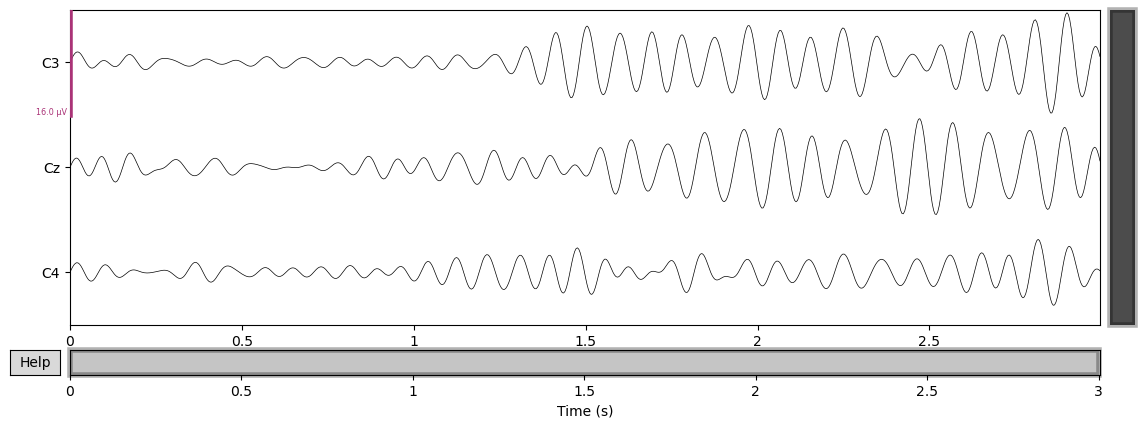

In [115]:
# Seleccionamos un epoch 
epoch_idx = 0
data = filtered_mu[epoch_idx, :, :]  # (3, n_times)
# Crear objeto Info para plotear
ch_names = ['C3', 'Cz', 'C4']
sfreq = 250
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
# Crear objeto RawArray
raw_mu = mne.io.RawArray(data, info)
# Graficar señal filtrada en banda mu
fig = raw_mu.plot(scalings={'eeg': 8e-6}, show=False) # Escalamos manualmente para mejor visualización
fig.set_size_inches(12, 4)
plt.show()

Creating RawArray with float64 data, n_channels=3, n_times=751
    Range : 0 ... 750 =      0.000 ...     3.000 secs
Ready.


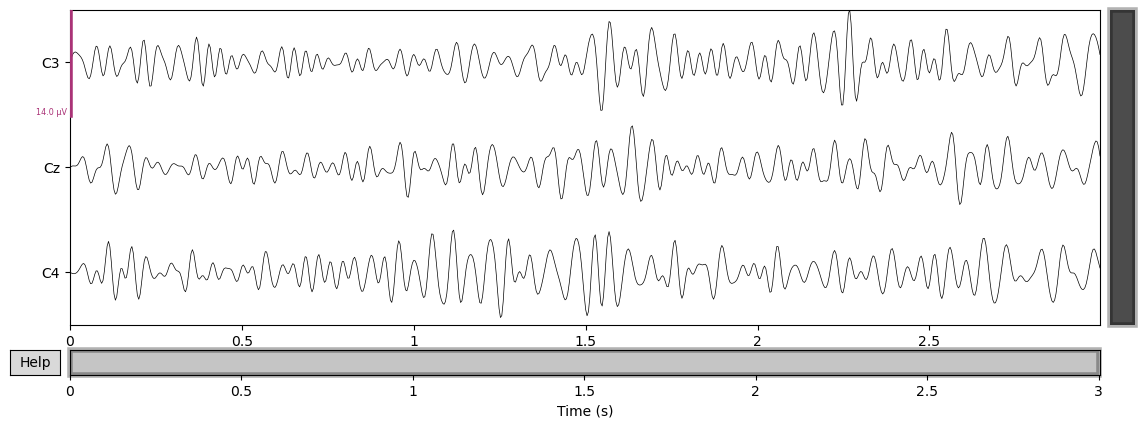

In [116]:
# Seleccionamos un epoch 
epoch_idx = 0
data = filtered_beta[epoch_idx, :, :]  # (3, n_times)
# Crear objeto Info para plotear
ch_names = ['C3', 'Cz', 'C4']
sfreq = 250
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
# Crear objeto RawArray
raw_beta = mne.io.RawArray(data, info)
# Graficar señal filtrada en banda mu
fig = raw_beta.plot(scalings={'eeg': 7e-6}, show=False) # Escalamos manualmente para mejor visualización
fig.set_size_inches(12, 4)
plt.show()

## **3. Preparación de los datos y definición de funciones**

### ***3.1. Cargar datos***

In [117]:
def cargar_gdf_carpeta(ruta_carpeta, sujeto = None):
    archivos_gdf = [f for f in os.listdir(ruta_carpeta)
                    if f.lower().endswith('t.gdf') and (sujeto.lower() in f.lower() if sujeto else True)]
    archivos_gdf.sort()
    if not archivos_gdf:
        raise FileNotFoundError("No se encontraron archivos .gdf en la carpeta especificada.")
    raws = []
    # Cargar cada archivo
    for archivo in archivos_gdf:
        ruta_completa = os.path.join(ruta_carpeta, archivo)
        print(f"Cargando: {archivo}")
        raw = mne.io.read_raw_gdf(ruta_completa, preload=True)
        # Eliminar canales EOG pues no son necesarios para el análisis EEG
        eog_canales = [ch for ch in raw.ch_names if 'EOG' in ch]
        raw.drop_channels(eog_canales)
        raws.append(raw)
    # Concatenar todas las sesiones en un solo objeto Raw
    raw_concat = mne.concatenate_raws(raws)
    return raw_concat

# Unicamente entrenaremos el modelo para el sujeto B01
ruta = "./Dataseets/BCICIV_2b_gdf" # Cambiar ruta de ser necesario
raw_all = cargar_gdf_carpeta(ruta, sujeto='B01') # Puede cambiarse el sujeto a 'B01', 'B02', etc.


Cargando: B0101T.gdf
Extracting EDF parameters from f:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Dataseets\BCICIV_2b_gdf\B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\dell\AppData\Local\Temp\ipykernel_15096\1225391179.py:12: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(ruta_completa, preload=True)


Cargando: B0102T.gdf
Extracting EDF parameters from f:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Dataseets\BCICIV_2b_gdf\B0102T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 552451  =      0.000 ...  2209.804 secs...


C:\Users\dell\AppData\Local\Temp\ipykernel_15096\1225391179.py:12: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(ruta_completa, preload=True)


Cargando: B0103T.gdf
Extracting EDF parameters from f:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Dataseets\BCICIV_2b_gdf\B0103T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 469010  =      0.000 ...  1876.040 secs...


C:\Users\dell\AppData\Local\Temp\ipykernel_15096\1225391179.py:12: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(ruta_completa, preload=True)


In [118]:
print(len(raw_all._filenames)) # Verificamos que se hayan cargado 3 sesiones (archivos .gdf) para el sujeto B01

3


### ***3.2. Segmentación en epochs, eventos y clases***

In [119]:
events = mne.events_from_annotations(raw_all)
print(events)

Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
(array([[      0,       0,       8],
       [    499,       0,       6],
       [  16749,       0,       7],
       ...,
       [1622466,       0,       9],
       [1623216,       0,      10],
       [1623341,       0,      12]]), {'1023': 1, '1077': 2, '1078': 3, '1079': 4, '1081': 5, '276': 6, '277': 7, '32766': 8, '768': 9, '769': 10, '770': 11, '781': 12})


In [120]:
epochs = mne.Epochs(raw_all, events=events[0], event_id=[10, 11], tmin = 1, tmax = 4, baseline=None)
epochs.get_data().shape # Nos muestra 120 epochs para el B0101, 120 para el B0102 y 160 para el B0103, total 400 epochs
# Considerar: Todos los archivos B0X03T tendran "smiley feedback" al igual que todos los archivos de evaluacion, pero esto
# no deberia comprometer el analisis realizado.

Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 400 events and 751 original time points ...
0 bad epochs dropped


(400, 3, 751)

C:\Users\dell\AppData\Local\Temp\ipykernel_15096\3334254861.py:15: RuntimeWarning: event 12 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
C:\Users\dell\AppData\Local\Temp\ipykernel_15096\3334254861.py:15: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


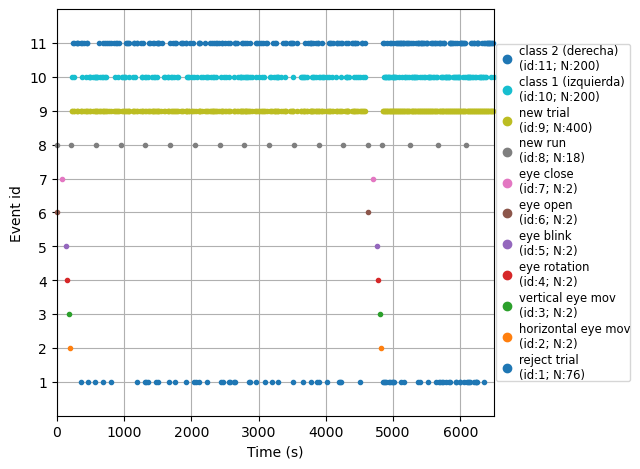

In [121]:
event_dict = {
    'reject trial': 1, # No lo necesitamos
    'horizontal eye mov': 2, # No lo necesitamos
    'vertical eye mov': 3, # No lo necesitamos
    'eye rotation': 4, # No lo necesitamos
    'eye blink': 5, # No lo necesitamos
    'eye open': 6, # No lo necesitamos
    'eye close': 7, # No lo necesitamos
    'new run': 8, # Inicio de una nuevo ensayo
    'new trial': 9, # Ensayos que debemos descartar debido a que contienen artefactos (Etiquetados por expertos)
    'class 1 (izquierda)': 10, # Imaginacion motora de mano izquierda
    'class 2 (derecha)': 11, # Imaginacion motora de mano derecha
}
# Visualizamos los eventos
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
# Considerar: Como menciona el paper, para los archivos B0102T y B0504E no se dieron grabaciones de EOG, por eso para
# evaluar al primer sujeto no se tiene grabaciones de EOG, pero no deberia importarnos a nosotros pues no usaremos
# dichos canales en nuestro analisis.

In [122]:
features = epochs.get_data() # Ahora si obtenemos los features que es lo principal para nuestro analisis

Using data from preloaded Raw for 400 events and 751 original time points ...


In [123]:
labels = epochs.events[:, -1] -10 # Lo usaremos para entrenar el CSP
labels

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,

### ***3.3. Banco de filtros***

In [124]:
def filter_band_features(features, fs, flow, fhigh):
    filtered_features = filter_data(features, fs, flow, fhigh)
    return filtered_features

filtered_mu = filter_band_features(features, fs=250, flow=8, fhigh=13)
filtered_beta = filter_band_features(features, fs=250, flow=13, fhigh=30)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- F

In [125]:
# Corroboramos las dimensiones de los features filtrados (Deberia ser igual al N° epochs = 400)
print(filtered_mu.shape) 
print(filtered_beta.shape)

(400, 3, 751)
(400, 3, 751)


### ***3.4. Entrenamiento del algoritmo CSP***

In [126]:
# Limitamos a 2 componentes para visualización pues unicamente tenemos 3 canales EEG
csp_mu = CSP(n_components=2, reg=None, log=True, norm_trace=False, cov_est='epoch')
X_csp_mu = csp_mu.fit_transform(filtered_mu, labels)
csp_beta = CSP(n_components=2, reg=None, log=True, norm_trace=False, cov_est='epoch')
X_csp_beta = csp_beta.fit_transform(filtered_beta, labels)
print(X_csp_mu.shape)
print(X_csp_beta.shape)


Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 3 dim * 1.2e+09  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Estimating class=0 covariance (average over epochs; EMPIRICAL)
Estimating class=1 covariance (average over epochs; EMPIRICAL)
Computing rank from data with rank=None
    Using tolerance 8.9e-07 (2.2e-16 eps * 3 dim * 1.3e+09  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Estimating class=0 covariance (average over epochs; EMPIRICAL)
Estimating class=1 covariance (average over epochs; EMPIRICAL)
(400, 2)
(400, 2)


In [127]:
X_features = np.concatenate((X_csp_mu, X_csp_beta), axis=1)
print(X_features)
print("Features finales:", X_features.shape) # 400 de 4 epochs, representando las 4 características extraidas por FBCSP

[[-0.54709562  1.12084488 -0.68122029 -0.40704061]
 [-0.83542349 -1.08789509 -1.21397498 -0.76810747]
 [-1.43482186 -0.53554228 -1.37750303 -0.67145569]
 ...
 [-0.84602783 -0.97152881 -0.99395074 -1.26375272]
 [-1.15978819 -0.91665248 -0.90315735 -0.63693357]
 [-1.60212952 -0.78996226 -1.47089752 -1.07385955]]
Features finales: (400, 4)


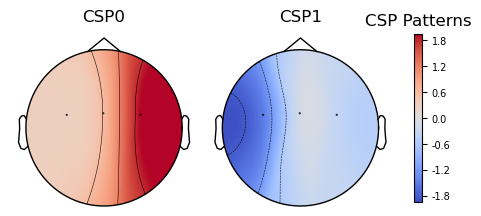

In [128]:
# Renombramos los canales para visualización de los patrones CSP segun el estándar 10-20
rename_dict = {
    'EEG:C3': 'C3',
    'EEG:Cz': 'Cz',
    'EEG:C4': 'C4',
}
epochs.rename_channels(rename_dict)
epochs.set_montage('standard_1020')
csp_mu.plot_patterns(
    info=epochs.info,
    ch_type='eeg',
    units='CSP Patterns',
    size=1.5,
    cmap='coolwarm',
    show=False
)

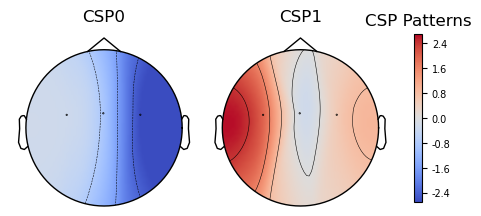

In [129]:
csp_beta.plot_patterns(
    info=epochs.info,
    ch_type='eeg',
    units='CSP Patterns',
    size=1.5,
    cmap='coolwarm',
    show=False
)

### ***3.5. Entrenamiento del clasificador LDA***

In [130]:
cv = KFold(n_splits=10, shuffle=True, random_state=42) # Validación cruzada con 10 folds
epochs_data = 1e6 * epoch.get_data() # Escalamos los datos a microvoltios
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X_features, labels, cv=cv, n_jobs=1)
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
print("Accuracy promedio: %.3f ± %.3f" % (scores.mean(), scores.std()))

Using data from preloaded Raw for 120 events and 751 original time points ...
CSP + LDA Classification accuracy: 0.755000 / Chance level: 0.500000
Accuracy promedio: 0.755 ± 0.055


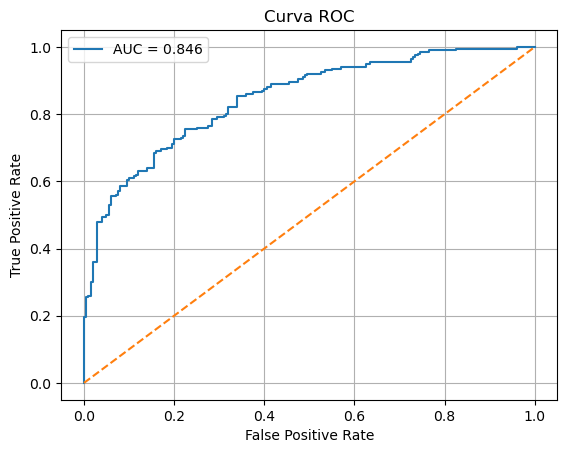

In [131]:
proba = cross_val_predict(lda, X_features, labels, cv=cv, method='predict_proba')
fpr, tpr, thr = roc_curve(labels, proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.close('all')  # cierra los plots de MNE anteriores
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

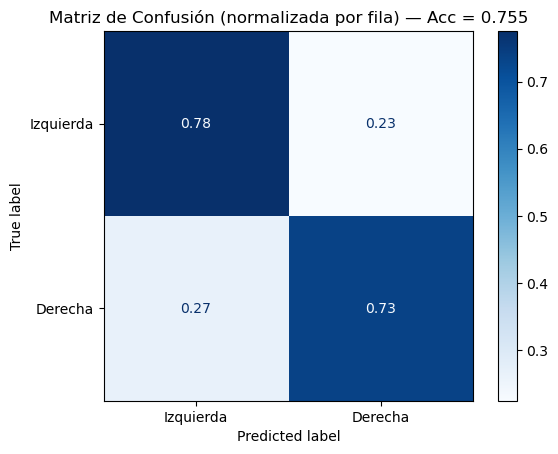

In [132]:
y_pred = cross_val_predict(lda, X_features, labels, cv=cv, method='predict')
cm = confusion_matrix(labels, y_pred) # conteos
acc = np.trace(cm) / cm.sum() # accuracy global

cm_norm = confusion_matrix(labels, y_pred, normalize='true')  # por filas
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                              display_labels=["Izquierda","Derecha"])
disp.plot(cmap='Blues', values_format='.2f')
plt.title(f"Matriz de Confusión (normalizada por fila) — Acc = {acc:.3f}")
plt.grid(False)
plt.show()

### ***3.6. Evaluación del Modelo***

In [133]:

# Unicamente entrenaremos el modelo para el sujeto B01
ruta = r'F:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\BCICIV_2b_gdf (1)\B0104E.gdf'
raw = mne.io.read_raw_gdf(ruta, preload = True)  
raw.drop_channels(['EOG:ch01', 'EOG:ch02', 'EOG:ch03']) # Eliminamos los canales de EOG, quedandonos con los 22 canales EEG

Extracting EDF parameters from F:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\BCICIV_2b_gdf (1)\B0104E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 466313  =      0.000 ...  1865.252 secs...


C:\Users\dell\AppData\Local\Temp\ipykernel_15096\1584182310.py:3: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(ruta, preload = True)


<RawGDF | B0104E.gdf, 3 x 466314 (1865.3 s), ~10.7 MiB, data loaded>

In [134]:
events = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw_all, events=events[0], event_id=[10, 11], tmin = 1, tmax = 4, baseline=None)
epochs.get_data().shape

Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '781', '783']
Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 320 events and 751 original time points ...
0 bad epochs dropped


(320, 3, 751)

C:\Users\dell\AppData\Local\Temp\ipykernel_15096\3790061626.py:15: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


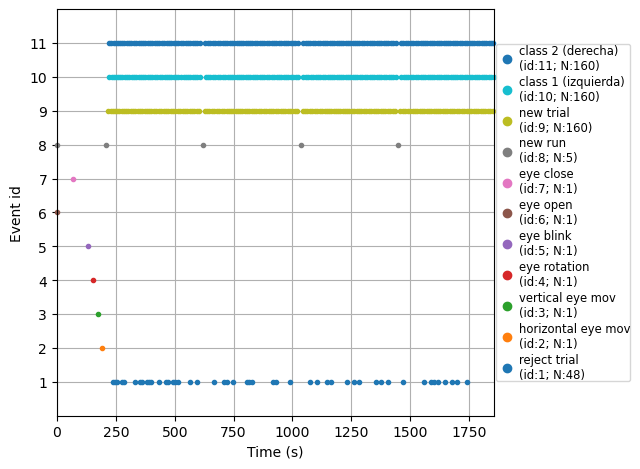

In [135]:
event_dict = {
    'reject trial': 1, # No lo necesitamos
    'horizontal eye mov': 2, # No lo necesitamos
    'vertical eye mov': 3, # No lo necesitamos
    'eye rotation': 4, # No lo necesitamos
    'eye blink': 5, # No lo necesitamos
    'eye open': 6, # No lo necesitamos
    'eye close': 7, # No lo necesitamos
    'new run': 8, # Inicio de una nuevo ensayo
    'new trial': 9, # Ensayos que debemos descartar debido a que contienen artefactos (Etiquetados por expertos)
    'class 1 (izquierda)': 10, # Imaginacion motora de mano izquierda
    'class 2 (derecha)': 11, # Imaginacion motora de mano derecha
}
# Visualizamos los eventos
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

In [136]:
features = epochs.get_data()
labels = epochs.events[:, -1] -10

Using data from preloaded Raw for 320 events and 751 original time points ...


In [137]:
filtered_mu = filter_band_features(features, fs=250, flow=8, fhigh=13)
filtered_beta = filter_band_features(features, fs=250, flow=13, fhigh=30)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- F

In [139]:
X_csp_mu = csp_mu.fit_transform(filtered_mu, labels)
X_csp_beta = csp_beta.fit_transform(filtered_beta, labels)
print(X_csp_mu.shape)
print(X_csp_beta.shape)
X_features = np.concatenate([X_csp_mu, X_csp_beta], axis=1)

Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Estimating class=0 covariance (average over epochs; EMPIRICAL)
Estimating class=1 covariance (average over epochs; EMPIRICAL)
Computing rank from data with rank=None
    Using tolerance 8.7e-07 (2.2e-16 eps * 3 dim * 1.3e+09  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Estimating class=0 covariance (average over epochs; EMPIRICAL)
Estimating class=1 covariance (average over epochs; EMPIRICAL)
(320, 2)
(320, 2)


In [141]:
lda.fit(X_features, labels)
y_pred = lda.predict(X_features)
print("\nPredicciones completadas.\n")


Predicciones completadas.



In [142]:
eventos = epochs.events[:, -1]  # códigos de evento de cada epoch
for i in range(len(y_pred)):
    print(f"Epoch {i}: etiqueta real = {labels[i]}, evento = {eventos[i]}, predicción = {y_pred[i]}")


Epoch 0: etiqueta real = 1, evento = 11, predicción = 1
Epoch 1: etiqueta real = 0, evento = 10, predicción = 1
Epoch 2: etiqueta real = 1, evento = 11, predicción = 1
Epoch 3: etiqueta real = 0, evento = 10, predicción = 1
Epoch 4: etiqueta real = 1, evento = 11, predicción = 1
Epoch 5: etiqueta real = 0, evento = 10, predicción = 1
Epoch 6: etiqueta real = 1, evento = 11, predicción = 0
Epoch 7: etiqueta real = 0, evento = 10, predicción = 0
Epoch 8: etiqueta real = 1, evento = 11, predicción = 0
Epoch 9: etiqueta real = 0, evento = 10, predicción = 0
Epoch 10: etiqueta real = 1, evento = 11, predicción = 1
Epoch 11: etiqueta real = 0, evento = 10, predicción = 1
Epoch 12: etiqueta real = 1, evento = 11, predicción = 1
Epoch 13: etiqueta real = 0, evento = 10, predicción = 1
Epoch 14: etiqueta real = 1, evento = 11, predicción = 0
Epoch 15: etiqueta real = 0, evento = 10, predicción = 0
Epoch 16: etiqueta real = 1, evento = 11, predicción = 1
Epoch 17: etiqueta real = 0, evento = 10,